# Chapter 11 - Attention Mechanisms and Transformers

The core idea behind the Transformer model is the *attention mechanism*, an innovation that was originally envisioned as an enhancement for encoder-decoder RNNs applied to sequence-to-sequence applications.

## 11.1. Queries, Keys, and Values

In the simplest databases $\mathcal{D}$, they are collections of keys ($k$) and values ($v$). The keys are used to look up the values. We can operate on $\mathcal{D}$ with the exact query ($q$) for a key $k$ to retrieve the corresponding value $v$. If the key $k$ is not a record in $\mathcal{D}$, there would be no valid answer.
* We can design queries $q$ that operate on $(k, v)$ pairs in such a manner as to be valid regardless of the database size.
* The same query can receive different answers, according to the contents of the database.
* The "code" being executed for operating on a large state space (the database) can be quite simple (e.g., exact match, approximate match, top-$k$).
* There is no need to compress or simplify the database to make the operations effective.

In the context of deep learning, consider to denote by $\mathcal{D} \stackrel{\textrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$ a database of $m$ tuples of *keys* and *values*. Moreover, denote by $\mathbf{q}$ a *query*. Then, we can define the ***attention*** over $\mathcal{D}$ as
\begin{split}
\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,
\end{split}
where $\alpha(\mathbf{q}, \mathbf{k}_i)\in\mathbb{R}$ ($i=1,\ldots,m$) are scalar attention weights. This operation is referred to as *attention pooling*. The attention over $\mathcal{D}$ generates a linear combination of values contained in the database. Special cases of attention pooling are:
* The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ are nonnegative. The output of the attention mechanism in this case is contained in the convex cone spanned by the value vectors $\mathbf{v}_i$.
* The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ form a convex combination, i.e., $\sum_i \alpha(\mathbf{q}, \mathbf{k}_i) = 1$ and $\alpha(\mathbf{q}, \mathbf{k}_i) \geq 0$ for all $i$. This is the most common case in deep learning.
* Exactly one of the weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ is 1, while all others are 0. This is akin to a traditional database query.
* All weights are equal, i.e., $\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{1}{m}$ for all $i$. This amounts to averaging across the entire database, also called average pooling in deep learning.

Normalization to ensure that the weights sum up to 1:
\begin{split}
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{q}, \mathbf{k}_j)}
\end{split}

To ensure that the weights are also nonnegative, we can resort to exponentiation, which means that we can now pick *any* function $\alpha(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it:
\begin{split}
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}
\end{split}

The figure below illustrates the attention mechanism computing a linear combination over value vectors via attention pooling.

![](../imgs/ch11/qkv.svg)

In [1]:
import torch
from d2l import torch as d2l

### 11.1.1. Visualization

When the weights are nonnegative and sum to 1, we may interpret large weights as a way for the model to select components of relevance. We can visualize its effect on the given set of keys when applying a variety of different queries.

The `show_heatmaps` function below takes a tensor with 4 axes, allowing for an array of different queries and weights. The input `matrices` has the shape (number of rows for display, number of columns for display, number of queries, number of keys).

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(3,3), cmap='Reds'):
    '''Show heatmaps of matrices'''
    d2l.use_svg_display() # Use svg format to display plots in jupyter

    # matrices should be a 4D tensor
    num_rows, num_cols, _, _ = matrices.shape

    fig, axes = d2l.plt.subplots(
        num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False
    )

    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)

            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    fig.colorbar(pcm, ax=axes, shrink=0.6);

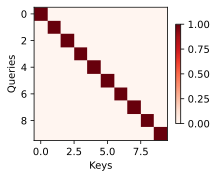

In [3]:
# prepare a toy 4D attention matrix
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 11.2. Attention Pooling by Similarity

The attention mechanism can also be used in the kernel density estimation. In this case, the estimators rely on some similarity kernel $\alpha(\mathbf{q}, \mathbf{k})$ relating queries $\mathbf{q}$ and keys $\mathbf{k}$. Some common kernels are
\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechikov.}
\end{aligned}\end{split}
The kernels are sometimes called *Parzen windows* or *Nadaraya-Watson kernels*. All of the kernels are heuristic and can be tuned. All of them lead to the following eqaution for regression and classification alike:
\begin{split}
f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}.
\end{split}

In the case of a (scalar) regression with observations $(\mathbf{x}_i, y_i)$ for features and labels, respectively, $\mathbf{v}_i=y_i$ are scalars, $\mathbf{k}_i = \mathbf{x}_i$ are feature vectors, and the query $\mathbf{q}$ denotes the new location where $f$ should be evaluated.

In the case of (multiclass) classification, we use one-hot-encoding of $y_i$ to obtain $\mathbf{v}_i$. Since these estimators require no training, we can narrow the kernels with increasing amounts of data. It will converge to some statistical optimal solution.

In [4]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

d2l.use_svg_display()

### 11.2.1. Kernels and Data

All the kernels $\alpha(\mathbf{q}, \mathbf{k})$ defined in this section are *translation and rotation invariant*, that is, if we shift and rotate $\mathbf{q}$ and $\mathbf{k}$ in the same manner, the value of $\alpha$ remains unchanged.

For simplicity we pick scalar arguments $k, q\in\mathbb{R}$ and pick the key $k=0$ as the origin.

In [5]:
# define kernels
def gaussian(x):
    return torch.exp(-x ** 2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

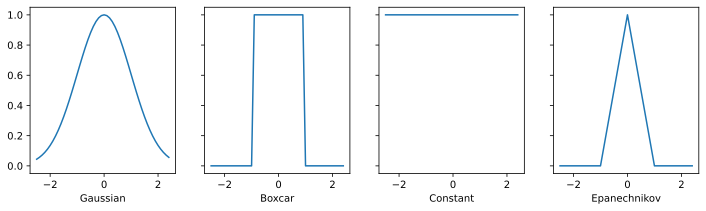

In [6]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechnikov')
x = torch.arange(-2.5, 2.5, 0.1)

for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

Different kernels correspond to different notions of range and smoothness. For instance, the boxcar kernel only attends to observations within a distance of 1 and does so indiscriminately.

To apply Nadaraya-Watson estimation, we need to define some training data. We use the following function to generate the data:
\begin{split}
y_i = 2\sin(x_i) + x_i + \epsilon,
\end{split}
where $\epsilon$ is drawn from a normal distribution with zero mean and unit variance.

In [7]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5) # Training inputs
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1) # Validation inputs
y_val = f(x_val)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([40]), torch.Size([40]), torch.Size([50]), torch.Size([50]))

### 11.2.2. Attention Pooling via Nadaraya-Watson Regression

After we created the training data and defined the kernels, we need a function to compute the kernel regression estimates. We also want to obtain the relative kernel weights in order to perform minor diagnostics. Hence, we compute the kernel between all training features (covariates) `x_train` and all validation features `x_val` first. This gives a matrix, which we subsequently normalize. When multiplied with the training labels `y_train`, we obtain the estimates.

Recall the attention pooling from the beginning of this section:
\begin{split}
\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,
\end{split}
Let each validation feature be a query, and each training feature-label pair be a key-value pair. As a result, the normalized relative kernel weights (`attention_w` below) are the *attention weights*.

In [15]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    # reshape x_train to (len(x_train), 1)
    x_train = x_train.reshape((-1, 1))
    # reshape x_val to (1, len(x_val))
    x_val = x_val.reshape((1, -1))
    # compute the difference between each element in x_val and x_train
    # dists.shape = (len(x_train), len(x_val))
    dists = x_train - x_val

    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)

    # normalization over keys for each query
    attention_w = k / k.sum(0)
    # attention_w.shape = (len(x_train), len(x_val))

    y_hat = y_train @ attention_w
    return y_hat, attention_w

In [16]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)

        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);

        ax.set_xlabel(name)

        if not attention:
            ax.legend(['y_hat', 'y'])

    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

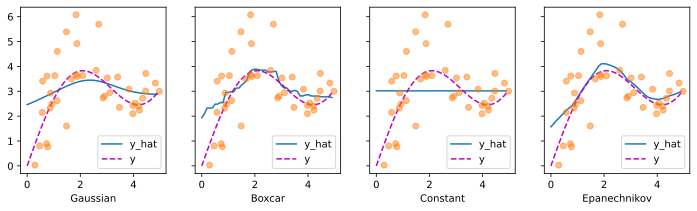

In [17]:
# check different kernels
plot(x_train, y_train, x_val, y_val, kernels, names, attention=False)

Gaussian, Boxcar and Epanechikov kernels produce fairly workable estimates that are not too far from the true funciton. Only the constant kernel produces a rather unrealistic result due to the fact that it does not use the features at all.

We can also inspectr the attention weighting:

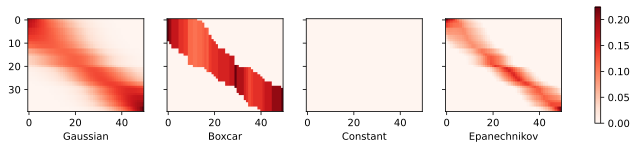

In [18]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The visualization shows that the attention weights for Gaussian, Boxcar, and Epanechikov kernels are very similar since they are derived from very similar attention weights, despite the different functional form of the kernels.

### 11.2.3. Adapting Attention Pooling

We could replace the Gaussian kernel with a different width that we could use $\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)$ where $\sigma^2$ determines the width of the kernel.

In [19]:
def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

In [20]:
sigmas = (0.1, 0.2, 0.5, 1.)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

kernels = [gaussian_with_width(sigma) for sigma in sigmas]

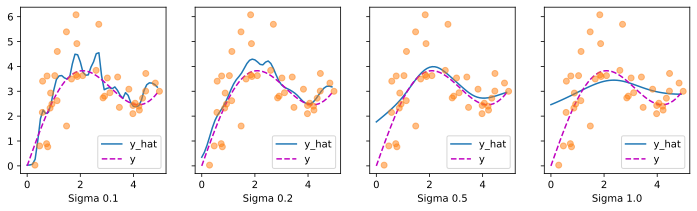

In [21]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=False)

The narrower the kernel, the less smooth the estimate. In addition, it adapts better to the local variations.

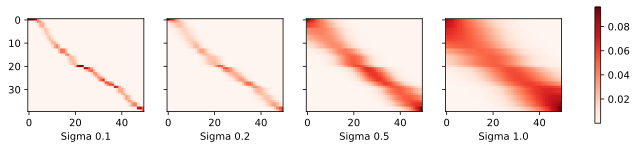

In [22]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The narrower the kernel, the narrower the range of large attention weights. Picking the same width may not be ideal.

## 11.3. Attention Scoring Functions

As we can see from the previous section, we can use many different *distance-based kernels*, including a Gaussian kernel, to model *interactions between queries and keys*. However, distance functions are mroe expensive to compute than dot products. For this reason, the attention mechanism is typically formulated in terms of a *scoring function* $a$, which is demonstrated in the figure below.

![](../imgs/ch11/attention-output.svg)

In [1]:
import math
import torch
from torch import nn

from d2l import torch as d2l

### 11.3.1. Dot Product Attention

The attention function (without exponentiation) from the Gaussian kernel:
\begin{split}
a(\mathbf{q}, \mathbf{k}_i) = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2  = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2  -\frac{1}{2} \|\mathbf{q}\|^2
\end{split}
There are two points to note here:
1. The third term $-\frac{1}{2} \|\mathbf{q}\|^2$ depends on the query $\mathbf{q}$ only. This is identical for all $(\mathbf{q}, \mathbf{k}_i)$ pairs. Normalizing the attention weights to 1, as is done in $\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}$, ensures that this term disappears entirely. 
2. Both batch and layer normalization lead to activations that have well-bounded, and often constant norms $\|\mathbf{k}_i\|$. This is the case whenever the keys $\mathbf{k}_i$ were generated by a layer norm. 

Thus, we can drop it from the definition of $a$ without any major change in the outcome:
\begin{split}
a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2
\end{split}

We also need to keep the order of magnitude of the arguments in the exponential function under control. Assume that all the elements of the query $\mathbf{q}\in\mathbb{R}^d$ and the key $\mathbf{k}_i\in\mathbb{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$.

To ensure that the variance of the dot product still remains 1 relardless of vector length, we use the *scaled dot product attention* scoring funtion. That is, we rescale the dot product by $1/\sqrt{d}$. Therefore, we arrive at the first commonly used attention function that is used in Transformers:
\begin{split}
a(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}
\end{split}

Note that the attention weights $\alpha$ still need normalizing. We can further simplify this by using the softmax operation:
\begin{split}
\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.
\end{split}

### 11.3.2. Convenience Functions

#### 11.3.2.1. Masked Softmax Operation

For sequence models, we need to be able to deal with sequences of different lengths. Such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences. These special tokens do not carry meaning. For example,
```
Dive  into  Deep    Learning
Learn to    code    <blank>
Hello world <blank> <blank>
```

Since we do not want blanks in our attention model, we simply need to limit $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ to $\sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ for $l\leq n$, the actual sentence length. This is called the *masked softmax operation*.

The implementation of the masked softmax operation is to set the values of $\mathbf{v}_i$, for $i>l$, to zero. It also sets the attention weights to a large negative number, such as $-10^6$, in order to make their contribution to gradients and values vanish in practice.

In [2]:
def masked_softmax(X, valid_lens):
    '''Perform softmax operation by masking elements on the last axis
    
    Parameters
    ----------
    X: torch.Tensor
        3D tensor with shape (batch_size, num_queries, num_keys)
    valid_lens: torch.Tensor
        1D tensor with shape (batch_size,) or 2D tensor with shape (batch_size, num_queries)
    '''

    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen),
                            dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X
    
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)

        # On the last axis, replace masked elements with a very large negative value,
        # whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Consider a minibatch of two examples of size $2\times 4$, where their valid length are 2 for the first example and 3 for the second example, respectively.

Inspect what the `masked_softmax` function does line by line:

In [3]:
# Example:
X = torch.rand(2, # batch_size
               2, # num_queries
               4) # num_keys
valid_lens = torch.tensor([2, # valid lengths for batch 1
                           3  # valid lengths for batch 2
                           ])
X

tensor([[[0.1251, 0.5462, 0.2847, 0.8729],
         [0.9295, 0.7822, 0.0961, 0.9977]],

        [[0.6061, 0.6240, 0.4775, 0.8903],
         [0.1723, 0.4200, 0.9088, 0.1929]]])

In [4]:
# valid_lens is not None
shape = X.shape
# check the dimension of valid_lens
shape, valid_lens.dim()

(torch.Size([2, 2, 4]), 1)

In [5]:
# valid_lens.dim() is 1
# then we need to use repeat_interleave to make valid_lens have the same number of queries as X
valid_lens_tmp = torch.repeat_interleave(valid_lens, repeats=shape[1])
valid_lens_tmp

tensor([2, 2, 3, 3])

Next we go into the `_sequence_mask` function:

In [6]:
# reshape X to 2D tensor
X_tmp = X.clone()
X_tmp = X_tmp.reshape(-1, shape[-1])
X_tmp, X_tmp.shape

(tensor([[0.1251, 0.5462, 0.2847, 0.8729],
         [0.9295, 0.7822, 0.0961, 0.9977],
         [0.6061, 0.6240, 0.4775, 0.8903],
         [0.1723, 0.4200, 0.9088, 0.1929]]),
 torch.Size([4, 4]))

In [7]:
# retrieve the second dimension 
maxlen = X_tmp.size(1)
maxlen

4

In [8]:
# create a 1D tensor with values from 0 to maxlen-1
tmp = torch.arange((maxlen),
                   dtype=torch.float32,
                   device=X_tmp.device)
tmp

tensor([0., 1., 2., 3.])

In [9]:
tmp = tmp[None, :] # add a new dimension at the beginning
valid_lens_tmp = valid_lens_tmp[:, None] # add a new dimension at the end
tmp, valid_lens_tmp

(tensor([[0., 1., 2., 3.]]),
 tensor([[2],
         [2],
         [3],
         [3]]))

In [10]:
# create a 2D mask tensor with shape (valid_lens, maxlen)
mask = tmp < valid_lens_tmp
mask

tensor([[ True,  True, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False]])

In [11]:
# assgin unmasked elements with 1e-6
X_tmp[~mask] = -1e6
X_tmp

tensor([[ 1.2510e-01,  5.4624e-01, -1.0000e+06, -1.0000e+06],
        [ 9.2949e-01,  7.8225e-01, -1.0000e+06, -1.0000e+06],
        [ 6.0609e-01,  6.2396e-01,  4.7749e-01, -1.0000e+06],
        [ 1.7235e-01,  4.2004e-01,  9.0875e-01, -1.0000e+06]])

Now the first example has only first two columns with valid values, and the second example has only first three columns with valid values.

In [12]:
# reshape X_tmp to its original shape
X_tmp = X_tmp.reshape(shape)
X_tmp

tensor([[[ 1.2510e-01,  5.4624e-01, -1.0000e+06, -1.0000e+06],
         [ 9.2949e-01,  7.8225e-01, -1.0000e+06, -1.0000e+06]],

        [[ 6.0609e-01,  6.2396e-01,  4.7749e-01, -1.0000e+06],
         [ 1.7235e-01,  4.2004e-01,  9.0875e-01, -1.0000e+06]]])

In [13]:
# check the softmax output
nn.functional.softmax(X_tmp, 
                      dim=-1
                      )

tensor([[[0.3962, 0.6038, 0.0000, 0.0000],
         [0.5367, 0.4633, 0.0000, 0.0000]],

        [[0.3451, 0.3514, 0.3035, 0.0000],
         [0.2289, 0.2932, 0.4780, 0.0000]]])

In [14]:
# should get exactly the same result as the above
masked_softmax(X, valid_lens)

tensor([[[0.3962, 0.6038, 0.0000, 0.0000],
         [0.5367, 0.4633, 0.0000, 0.0000]],

        [[0.3451, 0.3514, 0.3035, 0.0000],
         [0.2289, 0.2932, 0.4780, 0.0000]]])

If we need more fine-grained control to specify the valid length for each of the two vectors of every example, we use a two-dimensional tensor of valid lengths. For example,

In [15]:
# Example:
X = torch.rand(2, # batch_size
               2, # num_queries
               4) # num_keys
valid_lens = torch.tensor([
    [1, 3], # valid lengths for each query in batch 1
    [2, 4]  # valid lengths for each query in batch 2
                           ])
X

tensor([[[0.7630, 0.0200, 0.8549, 0.7243],
         [0.2026, 0.8983, 0.5084, 0.1203]],

        [[0.1186, 0.3101, 0.5609, 0.4088],
         [0.8915, 0.5956, 0.3061, 0.3753]]])

In [16]:
masked_softmax(X, valid_lens)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2292, 0.4596, 0.3112, 0.0000]],

        [[0.4523, 0.5477, 0.0000, 0.0000],
         [0.3451, 0.2567, 0.1922, 0.2060]]])

#### 11.3.2.2. Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices by one another. This is often used when we have minibatches of queries, keys, and values. More specifically, assume that
\begin{split}
\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}
\end{split}

Then the *batch matrix multiplication* (BMM) computes the elementwise product
\begin{split}
\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}
\end{split}

In [18]:
Q = torch.ones((2, 3, 4)) # 2 examples, 3 queries, 4 keys
K = torch.ones((2, 4, 6)) # 2 examples, 4 keys, 6 values

d2l.check_shape(torch.bmm(Q, K),
                (2, 3, 6))

### 11.3.3. Scaled Dot Product Attention

Recall the dot product attention in the previous function:
\begin{split}
a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.
\end{split}
In general, it requires that both the query and the key have the same vector length, say $d$, even though this can be addressed by replacing $\mathbf{q}^\top \mathbf{k}$ with with $\mathbf{q}^\top \mathbf{M} \mathbf{k}$ where $\mathbf{M}$ is a matrix suitably chosen for translating between both spaces.

In practice, we think of minibatches for efficiency, such as computing attention for $n$ queries and $m$ key-value pairs, where queries and keys are of length $d$ and values are of length $v$. The scaled dot product attention of queries $\mathbf{Q}\in\mathbb{R}^{n \times d}$, keys $\mathbf{K}\in\mathbb{R}^{m \times d}$, and values $\mathbf{V}\in\mathbb{R}^{m \times v}$ is
\begin{split}
\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.
\end{split}

When applying this to a minibatch, we need the batch matrix multiplication. In the following implementation of the scaled dot product attention, we use dropout for regularization:

In [19]:
class DotProductAttention(nn.Module):
    '''Scaled dot product attention'''
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, #queries, d)
    # Shape of keys   : (batch_size, #key-value_pairs, d)
    # Shape of values : (batch_size, #key-value_pairs, dim_v)
    # Shape of valid_lens: (batch_size, ) or (batch_size, #queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]

        # swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, # (batch_size, #queries, d)
                           keys.transpose(1, 2), # (batch_size, d, #key-value_pairs)                  
                           ) / math.sqrt(d) # (batch_size, #queries, #key-value_pairs)

        self.attention_weights = masked_softmax(scores, valid_lens)

        out = torch.bmm(self.dropout(self.attention_weights), # (batch_size, #queries, #key-value_pairs)
                        values, # (batch_size, #key-value_pairs, dim_v)
                        ) # (batch_size, #queries, dim_v)
        return out

For example, assume that we have a minibatch size of 2, a total of 10 keys and values, and that the dimensionality of the values is 4. We also assume that the valid length per observation is 2 for the first example and 6 for the second example, respectively. Given that, we expect the output to be a $2\times 1\times 4$ tensor, i.e., one row per example of the minibatch.

In [20]:
batch_size = 2
num_queries = 1
d = 2
num_key_val_pairs = 10
dim_v = 4
valid_lens = torch.tensor([2, 6])

queries = torch.normal(0, # mean
                       1, # std
                       size=(batch_size, num_queries, d))
keys = torch.normal(0, # mean
                    1, # std
                    size=(batch_size, num_key_val_pairs, d))
values = torch.normal(0, # mean
                      1, # std
                      size=(batch_size, num_key_val_pairs, dim_v))

In [21]:
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens).shape

torch.Size([2, 1, 4])

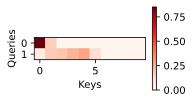

In [22]:
# check if attention weights vanish for anything beyong the second and sixth column respectively
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)),
    xlabel='Keys',
    ylabel='Queries'
)

### 11.3.4. Additive Attention

When queries $\mathbf{q}$ and keys $\mathbf{k}$ vectors of different dimension, we can either use a matrix to address the mismatch via $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, or we can use *additive attention* as the scoring function. The additive attention also saves minor computations compared to the dot product attention.

Given a query $\mathbf{q}\in\mathbb{R}^{q}$ and a key $\mathbf{k}\in\mathbb{R}^{k}$, the *additive attention* scoring function is defined as
\begin{split}
a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},
\end{split}
where $\mathbf W_q\in\mathbb{R}^{h\times q}$, $\mathbf W_k\in\mathbb{R}^{h\times k}$, and $\mathbf w_v\in\mathbb{R}^{h}$ are the learnable parameters. This is then fed into the softmax operation to obtain the attention weights:
\begin{split}
\alpha(\mathbf q, \mathbf k) = \textrm{softmax}(a(\mathbf{q}, \mathbf{k})).
\end{split}

The following implementation is to concatenate the query and the key and then feed into an MLP with a single hidden layer. It uses `tanh` activation and disables bias term:

In [23]:
class AdditiveAttention(nn.Module):
    '''Additive attention'''
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)

        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries = self.W_q(queries)
        keys = self.W_k(keys)

        # After dimension expansion,
        # shape of queries: (batch_size, #queries, 1, num_hiddens)
        # shape of keys   : (batch_size, 1, #key-value_pairs, num_hiddens)
        # Sum them up with boradcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)

        # There is only one output of self.w_v,
        # so we remove the last one-dimensional entry from the shape.
        # Shape of scores: (batch_size, #queries, #key-value_pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)

        # Shape of values: (batch_size, #key-value_pairs, dim_v)
        out = torch.bmm(self.dropout(self.attention_weights), values)
        return out

For example, we have a minibatch of 2 examples. We have 1 query of 20 dimensions and 10 keys of 2 dimensions. The values are of 4 dimensions. The valid lengths of the two examples are 2 and 6, respectively.

In [24]:
batch_size = 2
num_queries = 1
dim_q = 20
num_key_val_pairs = 10
dim_k = 2
dim_v = 4
valid_lens = torch.tensor([2, 6])

queries = torch.normal(0, # mean
                       1, # std
                       size=(batch_size, num_queries, dim_q))
keys = torch.normal(0, # mean
                    1, # std
                    size=(batch_size, num_key_val_pairs, dim_k))
values = torch.normal(0, # mean
                      1, # std
                      size=(batch_size, num_key_val_pairs, dim_v))

In [26]:
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens).shape

torch.Size([2, 1, 4])

This shape is the same as that of `DotProductAttention`.

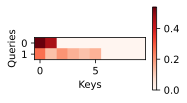

In [27]:
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)),
    xlabel='Keys',
    ylabel='Queries'
)

## 11.4. The Bahdanau Attention Mechanism

In an encoder-decoder architecture for sequence-to-sequence learning, the RNN encoder transforms a variable-length sequence into a *fixed-shape* context variable. Then, the RNN decoder generates the output (target) sequence token by token based on the generated tokens and the context variable.

![](../imgs/ch11/seq2seq-state.svg)

The figure above desmontrates some additional details of the encoder-decoder architecture. All relevant information about a source sequence in an RNN is translated into some internal *fixed-dimensional* state represetation by the encoder. This is the state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

However, this is infeasible for long sequences, such as a book chapter or a very long sentence.

The *Bahdanau attention mechanism* is a differentiable attention model *without* the unidirectional alignment limitation. When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are deemed relevant to the current prediction.

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

### 11.4.1. Model

The key idea of the Bahdanau attention mechanism is that instead of keeping the state, i.e., the context vairable $\mathbf{c}$ summarizing the source sentence, as fixed, we dynamically update it, as a function of both the original text (encoder hidden state $\mathbf{h}_t$) and the text that was already generated (decoder hidden state $\mathbf{s}_{t'-1}$). This yields $\mathbf{c}_{t'}$, which is updated after any decoding time step $t'$. 

Suppose that the input sequence is of length $T$. The context variable is the output of attention pooling:
\begin{split}
\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_{t}) \mathbf{h}_{t}
\end{split}
where we use $\mathbf{s}_{t' - 1}$ as the query, and $\mathbf{h}_{t}$ as both the key and the value. Note that $\mathbf{c}_{t'}$ is used to generate the state $\mathbf{s}_{t'}$ and to generate a new token, by recalling in the Section 10.7.3:
\begin{split}
\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1})
\end{split}

The attention weight $\alpha$ is compuated as in Section 11.3.1:
\begin{split}
\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i))
\end{split}
and the scoring function $a$ is defined as the additive attention scoring function in Section 11.3.4:
\begin{split}
a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}
\end{split}

![](../imgs/ch11/seq2seq-details-attention.svg)

This RNN encoder-decoder architecture using attention is illustrated in the figure above. This model later was modified to include the already generated tokens in the decoder as further context (i.e., the attention sum does not stop at $T$ but rather it proceeds up to $t'-1$).

### 11.4.2. Defining the Decoder with Attention

To implement the RNN encoder-decoder with attention, we only need to redefine the decoder (omitting the generated symbols from the attention function simplifies the design).

In [2]:
class AttentionDecoder(d2l.Decoder):
    '''The base attention-based decoder interface'''
    def __ini__(self):
        super().__init__()
 
    @property
    def attention_weights(self):
        raise NotImplementedError

We will implement the RNN decoder in the `Seq2SeqAttentionDecoder` class. The state of the decoder is initialized with
1. the *hidden states of the last layer* of the encoder at *all time steps*, used as **keys** and **values** for attention;
2. the *hidden state of the encoder* at *all layers* at the *final time step*, which serves to initialize the hidden state of the decoder; and,
3. the valid length of the encoder, to exclude the padding tokens in attention pooling.

At each decoding time step, the *hidden state of the final layer* of the decoder, obtained at the *previous time step*, is used as the **query** of the attention mechanism. Both the output of the attention mechanism and the input embedding are concatenated to serve as the input of the RNN decoder.

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        '''Sequence-to-sequence decoder with attention
        
        Parameters
        ----------
        vocab_size: int
            Size of the output vocabulary
        embed_size: int
            Embedding size
        num_hiddens: int
            Number of hidden units
        num_layers: int
            Number of layers
        dropout: float
            Dropout rate
        '''
        super().__init__()

        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, # input size
                          num_hiddens, # hidden size
                          num_layers, # number of layers
                          dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens)
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1,0,2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens)
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state

        # Shape of output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)

        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)

            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, # query shape: (batch_size, 1, num_hiddens)
                enc_outputs, # keys shape: (batch_size, num_steps, num_hiddens)
                enc_outputs, # values shape: (batch_size, num_steps, num_hiddens)
                enc_valid_lens # valid lengths for enc_outputs
            )

            # concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # reshape x as (1, batch_size, embed_size + num_hiddens)
            x = x.permute(1, 0, 2)
            # obtain new hidden state
            out, hidden_state = self.rnn(x, hidden_state)

            # append current output
            outputs.append(out)
            # append current attention weights
            self._attention_weights.append(self.attention.attention_weights)

        # After fully connected layer transformation,
        # Shape of outputs: (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))

        return outputs.permute(1,0,2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [7]:
# Example:
vocab_size = 10
embed_size = 8
num_hiddens = 16
num_layers = 2
batch_size = 4
num_steps = 7

X = torch.zeros((batch_size, num_steps), dtype=torch.long)

In [8]:
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)

state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

In [12]:
# Check the output shape
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
output.shape

torch.Size([4, 7, 10])

In [13]:
# Check the encoder output shape
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
state[0].shape

torch.Size([4, 7, 16])

In [14]:
# Check the first hidden state shape
d2l.check_shape(state[1][0], (batch_size, num_hiddens))
state[1][0].shape

torch.Size([4, 16])

### 11.4.3. Training

In [17]:
# Load the English-French dataset
data = d2l.MTFraEng(batch_size=128)
embed_size = 256
num_hiddens = 256
num_layers = 2
dropout = 0.2

# Create the encoder
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), # size of the input vocabulary
    embed_size, # embedding size
    num_hiddens, # number of hidden units
    num_layers, # number of layers
    dropout # dropout rate
)
# Create the decoder
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), # size of the output vocabulary
    embed_size, # embedding size
    num_hiddens, # number of hidden units
    num_layers, # number of layers
    dropout # dropout rate
)
# Create the sequence-to-sequence model
model = d2l.Seq2Seq(
    encoder, # encoder
    decoder, # decoder
    tgt_pad=data.tgt_vocab['<pad>'], # index of the padding token
    lr=0.005 # learning rate
)

# Create the trainer
trainer = d2l.Trainer(max_epochs=100, # number of epochs
                      gradient_clip_val=1, # gradient clipping
                      num_gpus=1) # number of GPUs

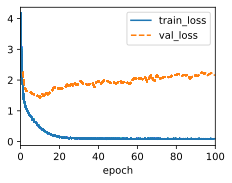

In [18]:
# Train the model
trainer.fit(model, data)

In [20]:
# Translate a few sentences
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

preds, _ = model.predict_step(
    data.build(engs, fras), # the input minibatch
    d2l.try_gpu(), # device
    data.num_steps, # number of decoding steps
)

for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)

    print(f"{en} => {translation}, BLEU,"
          f"{d2l.bleu(' '.join(translation), fr, k=2):.3f}")

go . => ['va', '!'], BLEU,1.000
i lost . => ["j'ai", 'perdu', '.'], BLEU,1.000
he's calm . => ['je', 'suis', 'calme', '.'], BLEU,0.537
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], BLEU,1.000


We can visualize the attention weights when translating the last English sentence.

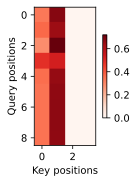

In [21]:
_, dec_attention_weights = model.predict_step(
    data.build(engs[-1], [fras[-1]]), # the input minibatch
    d2l.try_gpu(), # device
    data.num_steps, # number of decoding steps
    True # return the attention weights
)

attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0
)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# plus one to include the end-of sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions',
    ylabel='Query positions'
)

We can see that each query assign non-uniform weights over key-value pairs. It shows that at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

## 11.5. Multi-Head Attention

Given the same set of queries, keys, and values, we may want our model to combine knowledge from different behaviors of the same attention mechanism within a sequence.

Instead of performing a single attention pooling, the queries, keys, and values can be transformed with $h$ independently leanred linear projections. Then these $h$ projected queries, keys, and values are fed into attention pooling in parallel. In the end, $h$ attention-pooling outputs are concatenated and transformed with another learned linear projection to produce the final output. This design is called *multi-head attention*, where each of the $h$ attention pooling outputs is a *head*. The figure below illustrates multi-head attention using fully connected layers to perform learnable linear transformations.

![](../imgs/ch11/multi-head-attention.svg)

In [1]:
import math
import torch
from torch import nn

from d2l import torch as d2l

### 11.5.1. Model

Given a query $\mathbf{q}\in\mathbb{R}^{d_q}$, a key $\mathbf{k}\in\mathbb{R}^{d_k}$, and a value $\mathbf{v}\in\mathbb{R}^{d_v}$, each attention head $\mathbf{h}_i$ ($i=1,\ldots,h$) is computed as
\begin{split}
\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},
\end{split}
where $\mathbf{W}_i^{(q)}\in\mathbb{R}^{p_q\times d_q}$, $\mathbf{W}_i^{(k)}\in\mathbb{R}^{p_k\times d_k}$, and $\mathbf{W}_i^{(v)}\in\mathbb{R}^{p_v\times d_v}$ are learnable parameters and $f$ is attention pooling, such as additive attention and scaled dot product attention in Section 11.3.

The multi-head attention output is another linear transformation via learnable parameters $\mathbf{W}^{(o)}\in\mathbb{R}^{p_o\times h p_v}$ of the oncatenation of $h$ heads:
\begin{split}
\mathbf{o} = \mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.
\end{split}

### 11.5.2. Implementation

We will implement the multi-head attention with the scaled dot product attention for each head of the multi-head attention.

To avoid significant growth of computational cost and parametrization cost, we set $p_q=p_k=p_v=p_o/h$. The $h$ heads can be computed in parallel if we set the number of outputs of linear transformations for the query, key, and value to $p_q/h=p_k/h=p_v/h=p_o$ and $p_o$ is specified via the `num_hiddens`:

In [4]:
class MultiHeadAttention(d2l.Module):
    '''Multi-head attention'''
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()

        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, num_queries or num_key_value_pairs, num_hiddens)
        # Shape of valid_lens: (batch_size, ) or (batch_size, num_queries)

        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, num_queries or num_key_value_pairs, num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads times,
            # then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, # shape: (batch_size, )
                repeats=self.num_heads, # repeat for num_heads times
                dim=0 # repeat along axis 0
            )

        # Shape of output:
        # (batch_size * num_heads, num_queries, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat:
        # (batch_size, num_queries, num_hiddens)
        output_concat = self.transpose_output(output)

        return self.W_o(output_concat)
    

    # Transposition methods to allow for parallel computation of multiple heads
    def transpose_qkv(self, X):
        '''Transposition for parallel computation of multiple heads'''
        # Shape of input X:
        # (batch_size, num_queries or num_key_value_pairs, num_hiddens)
        # Shape of output X:
        # (batch_size, num_queries or num_key_value_pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)

        # Shape of output X:
        # (batch_size, num_heads, num_queries or num_key_value_pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)

        # Shape of output:
        # (batch_size * num_heads, num_queries or num_key_value_pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    def transpose_output(self, X):
        '''Reverse the operation of transpose_qkv'''
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

In [6]:
# Example:
num_hiddens = 100
num_heads = 5
batch_size = 2
num_queries = 4
num_kvpairs = 6
valid_lens = torch.tensor([3, 2])

X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))

attention = MultiHeadAttention(num_hiddens, num_heads, dropout=0.4)

d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## 11.6. Self-Attention and Positional Encoding

Instead of using CNNs or RNNs to encode sequences, we can use attention mechanisms to feed a sequence of tokens into an attention mechanism su that at every step, each token has its own query, keys, and values. When computing the value of a token's representation at the next layer, the token can attend (via its query vector) to any other's token (matching based on their key vectors). Using the full set of query-key compatibility scores, we can compute, for each token, a representation by building the appropriate weighted sum over the other tokens.

Because every token is attending to each other token (unlike the case where decoder steps attend to encoder steps), such architectures are called *self-attention* models.

In [1]:
import math
import torch
from torch import nn

from d2l import torch as d2l

### 11.6.1. Self-Attention

Given a sequence of input tokens $\mathbf{x}_1, \ldots, \mathbf{x}_n$ where any $\mathbf{x}_i\in\mathbb{R}^d$ ($i=1,\ldots,n$), its self-attention outputs a seuqnce of the same length $\mathbf{y}_1, \ldots, \mathbf{y}_n$ where
\begin{split}
\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d
\end{split}
according to the definition of attention pooling.

Using multi-head attention, we can compute the self-attention of a tensor with shape (batch size, number of time steps or sequence length in tokens, $d$). The output tensor has the same shape:

In [9]:
num_hiddens = 100
num_heads = 5
batch_size = 2
num_queries = 4
valid_lens = torch.tensor([3, 2])

X = torch.ones((batch_size, num_queries, num_hiddens))

attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout=0.5)

d2l.check_shape(
    attention(
        X, # queries
        X, # keys
        X, # values
        valid_lens # valid lengths
    ),
    (batch_size, num_queries, num_hiddens)
)
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

### 11.6.2. Comparing CNNs, RNNs, and Self-Attention

If we want to map a sequence of $n$ tokens to another one of equal length, where each input or output token is represented by a $d$-dimensional vector, we usually consider CNNs, RNNs, or self-attention. While a shorter path between any combination of sequence positions makes it easier to learn long-range dependencies within the sequence, the sequential operations prevent parallel computation.

Suppose we treat any text sequence a "one-dimensional image". 

![](../imgs/ch11/cnn-rnn-self-attention.svg)

**(CNNs)** Then, one-dimensional CNNs can process local features such as $n$-grams in text. Given a sequence of length $n$, consider a convolutional layer whose kernel size is $k$, and whose nujmbers of input and output channels are both $d$. The computational complexity of the convolutional layer is $\mathcal{O}(knd^2)$. The figure above shows that CNNs are *hierarchical*, so there are $\mathcal{O}(1)$ sequential operations and the maximum path length is $\mathcal{O}(n/k)$. For example, $\mathbf{x}_1$ and $\mathbf{x}_5$ are within the receptive field of a two-layer CNN with kernel size 3 in the figure above.

**(RNNs)** When updating the hidden state of RNNs, multiplication of the $d\times d$ weight matrix and the $d$-dimensional hidden state has a computational complexity of $\mathcal{O}(d^2)$. Since the sequence length is $n$, the computational complexity of the recurrent layer is $\mathcal{O}(nd^2)$. The figure above shows that there are $\mathcal{O}(n)$ sequential operations that cannot be parallelized and the maximum path length is also $\mathcal{O}(n)$. 

**(Self-Attention)** In self-attention, the queries, keys, and values are all $n\times d$ matrices. Consider the scaled dot product attention, where an $n\times d$ matrix is multiplied by a $d\times n$ matrix, then the output $n\times n$ matrix is multiplied by an $n\times d$ matrix. As a result, the self-attention has a $\mathcal{O}(n^2d)$ computational complexity. The figure above shows that each token is directly connected to any other token via self-attention. Therefore, computation can be parallel with $\mathcal{O}(1)$ sequential operations and the maximum path length is also $\mathcal{O}(1)$.

All in all, both CNNs and self-attention enjoy parallel computation and self-attention has the shortest maximum path length. However, the quadratic computational complexity with respect to the sequence length makes self-attention prohibitively slow for very long sequences.

### 11.6.3. Positional Encoding

Unlike RNNs, which recurrently process tokens of a sequence one-by-one, the self-attention ditches sequential operations in favor of parallel computation, because the self-attention by itself does not preserve the order of the sequence.

The dominant approach for preserving information about the order of tokens is to represent this to the model as an additional input associated with each token. These inputs are called *positional encodings*, and they can either be learned or fixed *a priori*.

Suppose that the input representation $\mathbf{X}\in\mathbb{R}^{n\times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. The positional encoding outputs $\mathbf{X}+\mathbf{P}$ using a positional embedding matrix $\mathbf{P}\in\mathbb{R}^{n\times d}$ of the same shape, whose element on the $i$-th row and the $(2j)$-th or the $(2j+1)$-th column is
\begin{split}\begin{aligned} 
p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).
\end{aligned}\end{split}

In [2]:
class PositionalEncoding(nn.Module):
    '''Positional encoding'''
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()

        self.dropout = nn.Dropout(dropout)

        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))

        # numerator in the sine and cosine functions
        num = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)
        # denominator in the sine and cosine functions
        den = torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        X = num / den

        # 0::2 means starting from 0, incrementing by 2
        self.P[:, :, 0::2] = torch.sin(X)
        # 1::2 means starting from 1, incrementing by 2
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In the positional embedding matrix $\mathbf{P}$, rows correspond to positions within a sequence and columns represent different positional encoding dimensions.

For example,in the following code snippet, the 6th and the 7th columns of the positional embedding maxtrix have a higher frequency than the 8th and the 9th columns. The offset between the 6th and the 7th (same for the 8th and the 9th) columns is due to the alternation of since and cosine functions:

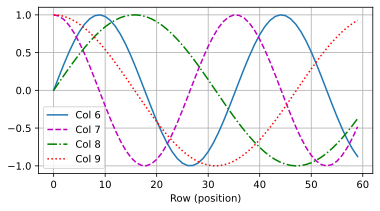

In [10]:
encoding_dim = 32
num_steps = 60

pos_encoding = PositionalEncoding(encoding_dim, dropout=0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]

d2l.plot(torch.arange(num_steps),
         P[0, :, 6:10].T,
         xlabel='Row (position)',
         figsize=(6, 3),
         legend=["Col %d" % d for d in torch.arange(6, 10)])

#### 11.6.3.1. Absolute Positional Information

To check how the monotonically decreased frequency along the encoding dimension relates to absolute positional information, we can check the binary representation of numbers from 0 to 7:

In [11]:
for i in range(8):
    print(f"{i} in binary is {i:>03b}")

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


In binary representations, a *higher bit* has a *lower frequency* than a *lower bit*. Similarly, as demonstrated in the heat map below, the positional encoding *decreases frequencies* along the encoding dimension by using trigonometric functions. Since the outputs are float numbers, such continuous representations are more space-efficient than binary representations.

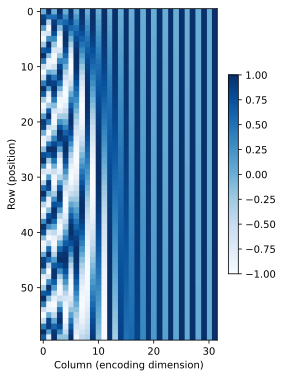

In [12]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)

d2l.show_heatmaps(
    P,
    xlabel='Column (encoding dimension)',
    ylabel='Row (position)',
    figsize=(4, 6),
    cmap='Blues'
)

#### 11.6.3.2. Relative Positional Information

This positional encoding also allows a model to easily learn to attend by relative positions, because for any fixed position offset $\delta$, the positional encoding at position $i+\delta$ can be represented as a linear projection of that at position $i$.

Denoting $\omega_j = 1/10000^{2j/d}$, any pair of $(p_{i, 2j}, p_{i, 2j+1})$ can be linearly projected to $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$ for any offset $\delta$:

\begin{split}
\begin{aligned}
\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=&
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}
\end{split}


## 11.7. The Transformer Architecture

The *Transformer* model is solely based on attention mechanisms without any convolutional or recurrent layer.

In [2]:
import math
import pandas as pd
import torch
from torch import nn

from d2l import torch as d2l

### 11.7.1. Model

![](../imgs/ch11/transformer.svg)

The figure above shows the architecture of the Transformer model with the encoder-decoder structure. In contrast to Bahdanau attention for sequence-to-sequence learning, the input (source) and output (target) sequence embeddings are added with positional encoding before being fed into the encoder and the decoder that stack modules based on self-attention.

(**Transformer Encoder**) At a high level, the Transformer encoder is a stack of multiple identical layers, where each layer has two sublayers (either is denoted as $\mathrm{sublayer}$):
    1. the first is a multi-head self-attention pooling, and
    2. the second is a positionwise feed-forward network.

In the encoder self-attention, the queries, keys, and values are all from the outputs of the previous encoder layer. Inspired by the ResNet design, a residual connection is employed around both sublayers. In the Transformer, for any input $\mathbf{x}\in\mathbb{R}^{d}$ at any position of the sequence, we require that $\mathrm{sublayer}(\mathbf{x})\in\mathbb{R}^{d}$ so that the residual connection $\mathbf{x}+\mathrm{sublayer}(\mathbf{x})\in\mathbb{R}^{d}$ is feasible. This addition from the residual connection is followed by layer normalization. Therefore, the Transformer encoder outputs a $d$-dimensional vector representation for each position of the input sequence.

(**Transformer Decoder**) The Transformer decoder is also a stack of multiple identical layers with residual connections and layer normalizations. In addition to the two sublayers described in the encoder, the decoder inserts a third sublayer, known as the *encoder-decoder attention*, between these two sublayers.

In the *encoder-decoder attention*, the queries are from the outputs of the decoder's self-attention sublayer, and the keys and values are from the Transformer encoder outputs. In the decoder self-attention, queries, keys, and values are all from the outputs of the previous decoder layer. However, each position in the decoder is allowed only to attend to all positions in the decoder up to that position. This *masked* attention preserves the autoregressive property, ensuing that the prediction only depends on those output tokens that have been generated.

### 11.7.2. Positionwise Feed-Forward Networks

The **positionwise feed-forward network** transforms the representation at all the sequence positions using the same MLP.

In the implementation below, the input `X` with shape (batch size, number of time steps or sequence length in tokens, number of hidden units or feature dimension) will be transformed by a two-layer MLP into an output tensor of shape (batch size, number of time steps, `ffn_num_outputs`):

In [3]:
class PositionWiseFFN(nn.Module):
    '''The position-wise feed-forward network'''
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()

        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        out = self.relu(self.dense1(X))
        out = self.dense2(out)

        return out

In [5]:
# Example:
X = torch.ones((2, 3, 4))

# create a position-wise feed-forward network
ffn = PositionWiseFFN(ffn_num_hiddens=4,
                      ffn_num_outputs=8)
# set the model in the evaluation mode
ffn.eval()

# check the output shape
ffn(X).shape

torch.Size([2, 3, 8])

In [6]:
ffn(X)

tensor([[[ 0.3553,  0.3328,  0.4353, -0.4509, -0.4185, -0.3955,  0.4928,
           0.0375],
         [ 0.3553,  0.3328,  0.4353, -0.4509, -0.4185, -0.3955,  0.4928,
           0.0375],
         [ 0.3553,  0.3328,  0.4353, -0.4509, -0.4185, -0.3955,  0.4928,
           0.0375]],

        [[ 0.3553,  0.3328,  0.4353, -0.4509, -0.4185, -0.3955,  0.4928,
           0.0375],
         [ 0.3553,  0.3328,  0.4353, -0.4509, -0.4185, -0.3955,  0.4928,
           0.0375],
         [ 0.3553,  0.3328,  0.4353, -0.4509, -0.4185, -0.3955,  0.4928,
           0.0375]]], grad_fn=<ViewBackward0>)

### 11.7.3. Residual Connection and Layer Normalization

In this small section, we focus on the "add & norm" component in the Transformer encoder and decoder. This is a residual connection immediately followed by a layer normalization. Both are key to effective deep architectures.

We have already known how batch normalization recenters and rescales across the examples within a mini-batch.

The *layer normalization* is the same as batch normalization except that the layer normalization *normalizes across the feature dimension*, thus enjoying benefits of scale independence and batch size independence.

Batch normalization is usually empirically less effective than layer normalization in natural language processing tasks, where the inputs are often variable-length sequences.

In [10]:
# layer normalization
ln = nn.LayerNorm(normalized_shape=2)
# batch normalization
bn = nn.LazyBatchNorm1d()

# Example:
X = torch.tensor(
    [[1, 2], [2, 3]],
    dtype=torch.float32
)

# compute mean and variance from X in the training mode
print('X shape:', X.shape)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

X shape: torch.Size([2, 2])
layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


The `AddNorm` class is used to implement the residual connection followed by layer normalization:

In [11]:
class AddNorm(nn.Module):
    '''The residual connection followed by layer normalization'''
    def __init__(self, norm_shape, dropout):
        super().__init__()

        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        Y = self.dropout(Y) # dropout
        # add the residual connection
        Y = Y + X
        # layer normalization
        Y = self.ln(Y)
        return Y

In [12]:
# Example:
add_norm = AddNorm(norm_shape=[3, 4],
                   dropout=0.5)

shape = (2, 3, 4)
X = torch.ones(shape)

d2l.check_shape(add_norm(X, X),
                shape)
add_norm(X, X).shape

torch.Size([2, 3, 4])

### 11.7.4. Encoder

![](../imgs/ch11/transformer.svg)

We will implement a single layer of the Transformer encoder in the `TransformerEncoderBlock` class, which contains two sublayers: multi-head self-attention and positionwise feed-forward networks, where a residual connection followed by layer normalization is employed around both sublayers.

In [13]:
class TransformerEncoderBlock(nn.Module):
    '''The Transformer encoder block'''
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()

        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        # multi-head attention
        Y = self.attention(X, X, X, valid_lens)
        # add and norm
        Y = self.addnorm1(X, Y)
        # position-wise feed-forward network
        Y = self.ffn(Y)
        # add and norm
        Y = self.addnorm2(X, Y)

        return Y

Note that *no layer in the Transformer encoder changes the shape of its input*:

In [15]:
# Example:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])

encoder_blk = TransformerEncoderBlock(num_hiddens=24,
                                      ffn_num_hiddens=48,
                                      num_heads=8,
                                      dropout=0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

We can implement the Transformer encoder by stacking `num_blks` instances of the above `TransformerEncoderBlock` classes. Since we use the fixed positional encoding whose values are always between -1 and 1, we multiply values of the learnable input embeddings by the square root of the embedding dimension to rescale before summing up the input embeding and the positional encoding:

In [18]:
class TransformerEncoder(d2l.Encoder):
    '''The Transformer encoder'''
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, use_bias=False):
        super().__init__()

        # number of hidden units
        self.num_hiddens = num_hiddens
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # positional encoding layer
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)

        # stack of encoder blocks
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                name='block'+str(i),
                module=TransformerEncoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias
                )
            )

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1,
        # the embedding values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        tmp_embed = self.embedding(X) * math.sqrt(self.num_hiddens)
        X = self.pos_encoding(tmp_embed)

        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights

        return X

We can create a *two-layer* Transformer encoder and the shape of the Transformer encoder output is (batch size, number of time steps or sequence length in tokens, number of hidden units or feature dimension):

In [20]:
vocab_size = 200
num_hiddens = 24
ffn_num_hiddens = 48
num_heads = 8
num_layers = 2
dropout = 0.5
valid_lens = torch.tensor([3, 2])

# Example:
X = torch.ones((2, 100), dtype=torch.long)

# create a transformer encoder
encoder = TransformerEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_layers, dropout)

encoder(X, valid_lens).shape # (batch_size, num_steps, num_hiddens)

torch.Size([2, 100, 24])

### 11.7.5. Decoder

![](../imgs/ch11/transformer.svg)

The Transformer decoder is composed of multiple identical layers. We will implement the `TransformerDecoderBlock` class, which contains three sublayers: decoder self-attention, encoder-decoder attention, and positionwise feed-forward networks. These sublayers employ a residual connection around them followed by layer normalization.

In the **masked multi-head self-attention** in the decoder (the first sublayer), the queries, keys, and values all come from the outputs of the previous decoder layer. When training sequence-to-sequence models, tokens at all the positions (time steps) of the output sequence are known.

However, during prediction the output sequence is generated token by token; thus, at any decoder time step only the generated tokens can be used in the decoder self-attention. To preserve autoregression in the decoder, its masked self-attention specifies `dec_valid_lens` so that any query only attends to all positions in the decoder up to the query position.

In [21]:
class TransformerDecoderBlock(nn.Module):
    '''The i-th Transformer decoder block'''
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()

        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)

        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        # During training, all the tokens of any output sequence are processed in parallel,
        # so state[2][self.i] is None as initialized.
        # When decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output
        # at the i-th block up to the current time step.
        if state[2][self.i] is None:
            # trianing mode
            key_values = X
        else:
            # prediction mode
            key_values = torch.cat(
                (state[2][self.i], X),
                dim=1
            )
        state[2][self.i] = key_values

        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where
            # every row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device
            ).repeat(batch_size, 1)

        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)

        # Encoder-Decoder attention
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)

        # Add and norm
        Z = self.addnorm2(Y, Y2)
        # Position-wise feed-forward network
        Z2 = self.ffn(Z)
        # Add and norm
        Z = self.addnorm3(Z, Z2)

        return Z, state

To facilitate **scaled dot product operations** in the *encoder–decoder attention* and **addition operations** in the *residual connections*, the feature dimension (`num_hiddens`) of the decoder is the same as that of the encoder.

In [25]:
# Example:
X = torch.ones((2, 100, 24))

# create a transformer decoder block
decoder_blk = TransformerDecoderBlock(num_hiddens=24,
                                      ffn_num_hiddens=48,
                                      num_heads=8,
                                      dropout=0.5,
                                      i=0)

state = [encoder_blk(X, valid_lens), valid_lens, [None]]

decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Now we build the entire Transformer decoder composed of `num_blks` instance of `TransformerDecoderBlock`.

In the end, a fully connected layer computes the prediction for all the `vocab_size` possible output tokens. Both of the decoder self-attention weights and the encoder-decoder attention weights are stored for later visualization:

In [26]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout):
        super().__init__()

        self.num_hiddens = num_hiddens
        self.num_blks = num_blks

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # positional encoding layer
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)

        # stack of decoder blocks
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                name='block' + str(i),
                module=TransformerDecoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, i
                )
            )

        # fully-connected output layer
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        # initialize the state
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]
    
    def forward(self, X, state):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        tmp_embed = self.embedding(X) * math.sqrt(self.num_hiddens)
        X = self.pos_encoding(tmp_embed)

        self._attention_weights = [
            [None] * len(self.blks) for _ in range(2)
        ]

        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)

            # decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights

        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

### 11.7.6. Training

In [31]:
# hyperparameters
num_hiddens = 256
num_blks = 2
dropout = 0.2
ffn_num_hiddens = 64
num_heads = 4

batch_size = 128
max_epochs = 100
lr = 0.001

In [32]:
# load the English-French dataset
data = d2l.MTFraEng(batch_size=batch_size)

# create the transformer encoder
encoder = TransformerEncoder(
    vocab_size=len(data.src_vocab),
    num_hiddens=num_hiddens,
    ffn_num_hiddens=ffn_num_hiddens,
    num_heads=num_heads,
    num_blks=num_blks,
    dropout=dropout
)
# create the transformer decoder
decoder = TransformerDecoder(
    vocab_size=len(data.tgt_vocab),
    num_hiddens=num_hiddens,
    ffn_num_hiddens=ffn_num_hiddens,
    num_heads=num_heads,
    num_blks=num_blks,
    dropout=dropout
)

# create the sequence-to-sequence model
model = d2l.Seq2Seq(
    encoder=encoder,
    decoder=decoder,
    tgt_pad=data.tgt_vocab['<pad>'],
    lr=lr
)

# create the trainer
trainer = d2l.Trainer(
    max_epochs=max_epochs,
    gradient_clip_val=1,
    num_gpus=1
)

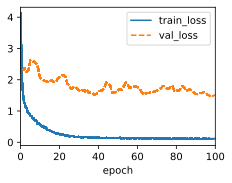

In [33]:
# train the model
trainer.fit(model, data)

After training, we can translate a few English sentences to French and compute their BLEU scores.

In [34]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

preds, _ = model.predict_step(
    data.build(engs, fras), # the input minibatch
    d2l.try_gpu(), # device
    data.num_steps, # number of decoding steps
)

for en, fr, p in zip(engs, fras, preds):
    translation = []

    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break

        translation.append(token)

    print(f'{en} => {translation}, bleu, '
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu, 1.000
i lost . => ["j'ai", 'perdu', '.'], bleu, 1.000
he's calm . => ['<unk>', '.'], bleu, 0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu, 1.000


We can also visualize the Transformer attention weights when translating the final English sentence into French.

The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, number of queries or `num_steps`, number of key-value pairs or `num_steps`). 

In [36]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], 
               [fras[-1]]), # last input minibatch
    d2l.try_gpu(), # device
    data.num_steps, # number of decoding steps
    True # return the attention weights
)

enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)

shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)

enc_attention_weights.shape

torch.Size([2, 4, 9, 9])

In the encoder self-attention, both queries and keys come from the same input sequence. Since padding tokens do not carry meaning, with specified valid length of the input sequence no query attends to positions of padding tokens. In the following, two layers of multi-head attention weights are presented row by row. Each head independently attends based on a separate representation subspace of queries, keys, and values.

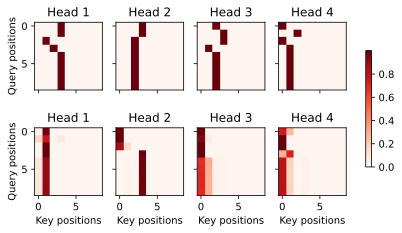

In [37]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), # encoder self-attention weights
    xlabel='Key positions',
    ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)
)

To visualize the decoder self-attention weights and the encoder–decoder attention weights, we need more data manipulations. For example, we fill the *masked attention weights* with zero. Note that the decoder self-attention weights and the encoder–decoder attention weights both have the same queries: the **beginning-of-sequence token** followed by the output tokens and possibly end-of-sequence tokens.

In [38]:
dec_attention_weights_2d = [
    head[0].tolist()
    for step in dec_attention_weights
    for attn in step
    for blk in attn 
    for head in blk
]

dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.).values
)

shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)

dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 9, 9]), torch.Size([2, 4, 9, 9]))

Because of the autoregressive property of the decoder self-attention, no query attends to key–value pairs after the query position.

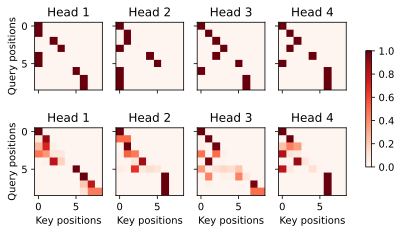

In [39]:
d2l.show_heatmaps(
    dec_self_attention_weights[:,:,:,:],
    xlabel='Key positions',
    ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)
)

Similar to the case in the encoder self-attention, via the specified valid length of the input sequence, no query from the output sequence attends to those padding tokens from the input sequence.

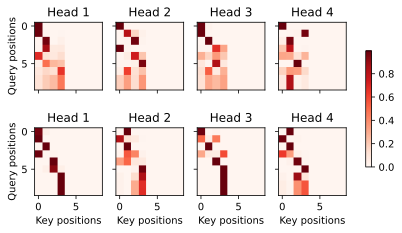

In [40]:
d2l.show_heatmaps(
    dec_inter_attention_weights,
    xlabel='Key positions',
    ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)
)

## 11.8. Transformers for Vision

Without specific constraints on patch size, the *vision Transformer* (ViT) extract patches from images and feed them into a Transformer encoder to obtain a global representation, which will finally be transformed for classification.

Transformers show better scalability than CNNs: and when training larger models on larger datasets, vision Transformers outperform ResNets by a significant margin.

In [41]:
import torch
from torch import nn

from d2l import torch as d2l

### 11.8.1. Model

![](../imgs/ch11/vit.svg)

The figure above shows the model architecture of vision Transformers, which consists of a stem that patchifies images, a body based on the multilayer Transformer encoder, and a head that transforms the global representation into the output label.

Consider an input image with height $h$, width $w$, and $c$ channels. Specifying the patch height and width both as $p$, the image is split into a sequence of $m = hw/p^2$ patches, where each patch is flattened into a vector of length $cp^2$.

Now, image patches can be treated similarly to tokens in text sequences by Transformer encoders. A special "`<cls>`" (class) token and the $m$ flattened image patches are linearly projected into a sequence of $m+1$ vectors, summed with learnable positional embeddings.

The multilayer Transformer encoder transforms $m+1$ input vectors into the same number of output vector representations of the same length. It works exactly the same as the Transformer encoder in the previous section, only differing in the position of normalization.

Since the "`<cls>`" token attends to all the image patches via self-attention, its representation from the Transformer encoder output will be further transformed into the output label.

### 11.8.2. Patch Embedding

Splitting an image into patches and linearly projecting these flattened patches can be simplified as a single convolution operation, where both the kernel size and the stride size are set to the patch size.

In [42]:
class PatchEmbedding(nn.Module):
    '''Patch embedding layer'''
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()

        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return X
        
        img_size = _make_tuple(img_size)
        patch_size = _make_tuple(patch_size)

        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        self.conv = nn.LazyConv2d(
            out_channels=num_hiddens,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, X):
        # Shape of X: (batch_size, num_channels, img_size[0], img_size[1])
        X = self.conv(X)
        # flatten X to (batch_size, num_channels, num_patches)
        X = X.flatten(2)
        # transpose X to (batch_size, num_patches, num_channels)
        X = X.transpose(1, 2)

        return X

In [44]:
# Example:
img_size = 96
patch_size = 16
num_hiddens = 512
batch_size = 4

X = torch.zeros(batch_size, 3, img_size, img_size)

# create a patch embedding layer
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
patch_emb(X).shape

torch.Size([4, 36, 512])

In [45]:
# check the number of patches
(img_size//patch_size) ** 2

36

### 11.8.3. Vision Transformer Encoder

The MLP of the vision Transformer encoder is slightly different from the positionwise FFN of the original Transformer encoder:
1. the activation function uses the *Gaussian error linear unit* (GELU), which can be considered as a smoother version of the ReLU;
2. the dropout is applied to the output of each fully connected layer in the MLP for regularization.

In [46]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()

        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dense1(x)
        x = self.gelu(x)
        x = self.dropout1(x)

        x = self.dense2(x)
        out = self.dropout2(x)

        return out

The vision Transformer encoder block implementation just follows the pre-normalization design, where normalization is applied right *before* multi-head attention or the MLP. In contrast to post-normalization ("add & norm" in the original Transformer), where normalization is placed right *after* residual connections, pre-normalization leads to more effective or efficient training for Transformers.

In [47]:
class ViTBlock(nn.Module):
    '''The Vision Transformer block'''
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()

        # layer normalization
        self.ln1 = nn.LayerNorm(norm_shape)
        # self-attention
        self.attention = d2l.MultiHeadAttention(
            num_hiddens, num_heads, dropout, use_bias
        )
        # layer normalization
        self.ln2 = nn.LayerNorm(norm_shape)
        # MLP
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        # self-attention
        Y = self.attention(
            *([self.ln1(X)] * 3), # query, key, and values are the same
            valid_lens
        )
        # add skip connection
        X = X + Y
        # layer normalization
        Y = self.ln2(X)
        # MLP
        Y = self.mlp(Y)
        # add skip connection
        Z = X + Y

        return Z

No vision Transformer encoder block changes its input shape:

In [49]:
# Example:
num_hiddens = 24
norm_shape = 24
mlp_num_hiddens = 48
num_heads = 8
dropout = 0.5

X = torch.ones((2, 100, 24))

encoder_blk = ViTBlock(
    num_hiddens, norm_shape, mlp_num_hiddens, num_heads, dropout
)
encoder_blk.eval()

encoder_blk(X).shape

torch.Size([2, 100, 24])

### 11.8.4. Putting It All Together

The forward pass of vision Transformers:
1. input images are fed into an `PatchEmbedding` instance, whose output is concatenated with the "`<cls>`" token embedding. They are summed with learnable positional embeddings before dropout.
2. the output is fed into the Transformer encoder that stacks `num_blks` instances of the `ViTBlock` class.
3. the representation of the "`<cls>`" token is projected by the network head.

In [50]:
class ViT(d2l.Classifier):
    '''The Vision Transformer'''
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, 
                 emb_dropout, blk_dropout, lr=0.1, use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        # patch embedding layer
        self.patch_embedding = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            num_hiddens=num_hiddens
        )
        # cls token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens)) # (1, 1, num_hiddens)
        # add cls token to the patch embeddings
        num_steps = self.patch_embedding.num_patches + 1

        # positional embeddings are learnable parameters
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens)
        ) # (1, num_steps, num_hiddens)

        # dropout layer
        self.dropout = nn.Dropout(emb_dropout)

        # stack of transformer blocks
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                name=f"block{i}",
                module=ViTBlock(
                    num_hiddens, num_hiddens, mlp_num_hiddens, num_heads, blk_dropout, use_bias
                )
            )
        
        # head
        self.head = nn.Sequential(
            nn.LayerNorm(num_hiddens),
            nn.Linear(num_hiddens, num_classes)
        )

    def forward(self, X):
        # patch embedding
        X = self.patch_embedding(X)

        # add cls token
        cls_token = self.cls_token.expand(X.shape[0], -1, -1)
        X = torch.cat((cls_token, X), dim=1)

        # add positional embedding
        X = X + self.pos_embedding
        # dropout
        X = self.dropout(X)

        # stack of transformer blocks
        for blk in self.blks:
            X = blk(X)

        # head
        out = self.head(X[:, 0])

        return out

### 11.8.5. Training

Training a vision Transformer on the Fashion-MNIST dataset is just like how CNNs were trained:

In [52]:
# load the Fashion-MNIST dataset
img_size = 96
patch_size = 16
batch_size = 128

data = d2l.FashionMNIST(batch_size=batch_size, resize=(img_size, img_size))

# hyperparameters
num_hiddens = 512
mlp_num_hiddens = 2048
num_heads = 8
num_blks = 2
emb_dropout = 0.1
blk_dropout = 0.1
lr = 0.1
max_epochs = 20

# create the ViT model
model = ViT(
    img_size=img_size,
    patch_size=patch_size,
    num_hiddens=num_hiddens,
    mlp_num_hiddens=mlp_num_hiddens,
    num_heads=num_heads,
    num_blks=num_blks,
    emb_dropout=emb_dropout,
    blk_dropout=blk_dropout,
    lr=lr
)

# create the trainer
trainer = d2l.Trainer(max_epochs=max_epochs, num_gpus=1)

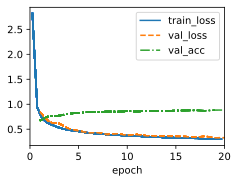

In [53]:
# train the model
trainer.fit(model, data)

Transformers lack useful principles in convolution, such as translation invariance and locality. The quadratic complexity of self-attention makes the Transformer architecture less suitable for higher-resolution images.

## 11.9. Large-Scale Pretraining with Transformers

Given larger data for pretraining, the Transformer architecture performs better with an increased model size and training compute, demonstrating superior *scaling* behavior. Performance of Transformer-based language models scales as a power law with the amount of model parameters, training tokens, and training compute.

### 11.9.1. Encoder-Only

When only the Transformer encoder is used, a sequence of input tokens is converted into the same number of representations that can be further projected into output (e.g., classification). A Transformer encoder consists of self-attention layers, where all input tokens attend to each other. 

Just like the vision Transformer we implemented in the previous section, it converts a sequence of input image patches into the representation of a special "`<cls>`" token. This design was inspired by an earlier encoder-only Transformer pretrained on text: BERT (*Bidirectional Encoder Representations from Transformers*).

#### 11.9.1.1. Pretraining BERT

BERT is pretrained on text sequences using *masked language modeling* (MLM): input text with randomly masked tokens is fed into a Transformer encoder to predict the masked tokens.

![](../imgs/ch11/bert-encoder-only.svg)

The figure above shows that an original text sequence "I", "love", "this", "red", "car", is prepended with the "`<cls>`" token, and the "`<mask>`" token randomly replaces "love"; then the cross-entropy loss between the masked token "love" and its prediction is to be minimized during pretraining.

There is not constraint in the attention pattern of Transformer encoders (right panel of the figure above) so all tokens can attend to each other. Thus, prediction of "love" depends on input tokens *before and after* it in the sequence. This is why BERT is a "*bidirectional encoder*".

#### 11.9.1.2. Fine-Tuning BERT